## DGA 데이터 전처리 : Part 4 측정가스 정보

<div style="text-align: right"> 작성자 : 유광명</div>  

<div style="text-align: right"> 1차 수정일: 2020.05.12 </div> 
<div style="text-align: right"> 최종 수정일: 2023.02.01 </div> 

### 0. 환경설정 및 데이터 로딩

In [1]:
from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 60

mpl.rcParams['axes.unicode_minus'] = False
_path = "c:\Windows\Fonts\KoPubWorld Dotum Bold.ttf"
_font_name = font_manager.FontProperties(fname=_path).get_name()
rc('font', family=_font_name)
mpl.rcParams['axes.unicode_minus']=False # 마이너스 폰트 깨짐방지

# 그래프 크기 설정
font_n = 15
font_d = 12
figure_hrz = 15

In [2]:
inputPath = 'result3.pkl'

In [3]:
df = pd.read_pickle(inputPath)

In [4]:
df.head(2)

,office1,office2,name,S/S,eq_type,eq_num,eq_phase,maker,volt,volt_by_name,operation,anal_type,mfg_year,sample_date,sample_year,sample_month,sample_season,age(year),age(month),long_term,H2,C2H2,C2H4,CH4,C2H6,C3H8,TCG,CO,CO2,r1(KEPCO),r2(KEPCO),etc
0,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,운전중,임시,1998,2017-01-11,2017,1,3,19,228,1,0.0,0.0,3.0,0.0,1.0,1.0,5.0,39.0,543.0,정상,정상,정밀점검 1개월후
1,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,운전중,임시,1998,2017-11-03,2017,11,2,19,238,1,13.0,0.0,2.0,1.0,1.0,2.0,19.0,117.0,1600.0,정상,정상,중부하 운전 변압기


### 4. 측정가스 정보 전처리  
- Gas 컬럼 : H2, C2H2, C2H4, CH4, C2H6, C3H8, TCG, CO, CO2

#### 4.1 TCG(Total Combustible Gases)

- 현 데이터의 TCG는 H2, C2H2, C2H4, CH4. C2H6, C3H8 컬럼의 합임
- 그런데 일반적인 DGA에서 C3H8(프로판)은 제외하고 TCG를 계산함
- TCG1 : H2, C2H2, C2H4, CH4. C2H6
- TCG2 : H2, C2H2, C2H4, CH4. C2H6, C3H8
- TG : TCG2 + CO + CO2

1) TCG1 컬럼 추가 : H2 + C2H2 + C2H4 + CH4 + C2H6

In [5]:
df['TCG1'] = df[['H2', 'C2H2', 'C2H4', 'CH4', 'C2H6']].sum(axis = 1)

2) TCG2 컬럼 추가 : H2 + C2H2 + C2H4 + CH4 + C2H6 + C3H8

In [6]:
df['TCG2'] = df[['H2', 'C2H2', 'C2H4', 'CH4', 'C2H6', 'C3H8']].sum(axis = 1)
df = df.drop('TCG', axis = 1)

3) TG 컬럼 추가 : TCG2 + CO + CO2

In [7]:
df['TG'] = df[['TCG2', 'CO', 'CO2']].sum(axis = 1)

#### 4.2 H2, C2H2, C2H4, CH4, C2H6, C3H8

1) **%Gas :** %H2, %C2H2, %C2H4, %CH4, %C2H6, %CO 컬럼 추가  
- Key Gas의 비율을 상태진단 인자로 사용
- 여기서 Key Gas는 'H2', 'C2H2', 'C2H4', 'CH4', 'C2H6', 'CO' 임(IEEE C57.104 참고)
- percent_gas 함수가 백분율(*100)을 리턴하도록 수정(5.12)
- **향 후:** Null 값 처리 코드 추가

In [8]:
# 현 데이터에는 null 값 없음
df[['H2', 'C2H2', 'C2H4', 'CH4', 'C2H6', 'CO']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134666 entries, 0 to 134665
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   H2      134666 non-null  float64
 1   C2H2    134666 non-null  float64
 2   C2H4    134666 non-null  float64
 3   CH4     134666 non-null  float64
 4   C2H6    134666 non-null  float64
 5   CO      134666 non-null  float64
dtypes: float64(6)
memory usage: 6.2 MB


In [9]:
def percent_gas(gas):
    total = gas[['H2', 'C2H2', 'C2H4', 'CH4', 'C2H6', 'CO']].sum()
    r1 = round(gas['H2']/total, 4)*100
    r2 = round(gas['C2H2']/total,4)*100
    r3 = round(gas['C2H4']/ total, 4)*100
    r4 = round(gas['CH4']/total, 4)*100
    r5 = round(gas['C2H6']/total, 4)*100
    r6 = round(gas['CO']/total, 4)*100
    return r1, r2, r3, r4, r5, r6

In [10]:
df[['%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO']] = \
    df[['H2', 'C2H2', 'C2H4', 'CH4', 'C2H6', 'CO']].apply(percent_gas, axis = 1,result_type="expand")

In [11]:
df[['%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO']].head()

,%H2,%C2H2,%C2H4,%CH4,%C2H6,%CO
0,0.00,0.0,6.98,0.00,2.33,90.70
1,9.70,0.0,1.49,0.75,0.75,87.31
2,0.00,0.0,1.05,0.00,0.53,98.42
3,0.62,0.0,0.88,0.66,0.09,97.75
4,0.65,0.0,1.04,0.72,1.41,96.18


In [12]:
df[['%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO']].describe()

,%H2,%C2H2,%C2H4,%CH4,%C2H6,%CO
count,133320.000000,133320.000000,133320.000000,133320.000000,133320.000000,133320.000000
mean,3.264559,0.188948,2.930164,6.725072,9.909266,76.981939
std,8.729481,2.151707,6.575501,9.037507,16.260588,26.257323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.760000,0.000000,59.750000
50%,0.450000,0.000000,1.090000,2.500000,0.340000,90.320000
75%,2.500000,0.000000,2.940000,11.110000,14.560000,97.740000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


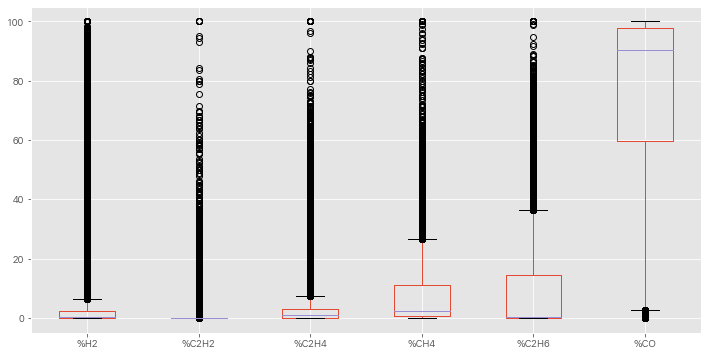

In [13]:
df[['%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO']].boxplot(figsize = (12, 6))

2) **Gas Ratio :** CH4/H2, C2H2/C2H4, C2H2/CH4, C2H6/C2H2, C2H4/C2H6 컬럼 추가
- CH4/H2, C2H2/C2H4, C2H2/CH4, C2H6/C2H2, C2H4/C2H6 : IEEE에서 사용하는 기준
- nan, inf 발생문제 해결
    * 분모가 0이 되는 문제 해결
    - **가스량이 0이거나, 작은 값인경우 S-values(IEC 60599 17page, IEC 60567)로 대체**  
    - H2: 5ppm, CH계열: 1ppm, CO: 25ppm, CO2: 25ppm

In [14]:
def ratio_gas(gas):
    H2_lim = 5.0; CH_lim = 1.0;
    cnt = 5 # 신뢰도, 높을수록 신뢰도가 높음...
    
    if gas['H2']<H2_lim:
        H2 = H2_lim
        cnt = cnt-1
    else :
        H2 = gas['H2']
        
    if gas['CH4']<=CH_lim:
        CH4 = CH_lim
        cnt = cnt-1
    else :
        CH4 = gas['CH4']
        
    if gas['C2H2']<=CH_lim:
        C2H2 = CH_lim
        cnt = cnt-1
    else :
        C2H2 = gas['C2H2']
        
    if gas['C2H4']<=CH_lim:
        C2H4 = CH_lim
        cnt = cnt-1
    else :
        C2H4 = gas['C2H4']
        
    if gas['C2H6']<=CH_lim:
        C2H6 = CH_lim
        cnt = cnt-1
    else :
        C2H6 = gas['C2H6']
        
    r1 = round(CH4/H2, 5)
    r2 = round(C2H2/C2H4, 5)
    r3 = round(C2H2/CH4, 5)
    r4 = round(C2H6/C2H2, 5)
    r5 = round(C2H4/C2H6, 5)
    return r1, r2, r3, r4, r5, int(cnt)

In [15]:
df[['CH4/H2', 'C2H2/C2H4', 'C2H2/CH4', 'C2H6/C2H2', 'C2H4/C2H6', 
    'gas_ratio_p']] = \
    df[['H2', 'CH4', 'C2H2', 'C2H4','C2H6']].apply(ratio_gas, 
                                            axis = 1,result_type="expand")
df['gas_ratio_p'] = df['gas_ratio_p'].astype('int16')

In [16]:
df[['CH4/H2', 'C2H2/C2H4', 'C2H2/CH4', 'C2H6/C2H2', 'C2H4/C2H6', 
    'gas_ratio_p']].describe()

,CH4/H2,C2H2/C2H4,C2H2/CH4,C2H6/C2H2,C2H4/C2H6,gas_ratio_p
count,134666.000000,134666.000000,134666.000000,134666.000000,134666.000000,134666.000000
mean,3.943505,0.579124,0.368888,48.161007,2.187696,2.321818
std,8.967008,12.403940,1.922336,107.891355,6.348153,1.388794
min,0.000030,0.000260,0.000130,0.001640,0.000270,0.000000
25%,0.240823,0.090910,0.035710,1.000000,0.209790,1.000000
50%,1.000000,0.333330,0.142860,1.200000,1.000000,3.000000
75%,3.600000,1.000000,0.500000,36.000000,1.516045,3.000000
max,1506.200000,4214.000000,385.000000,3744.000000,962.000000,5.000000


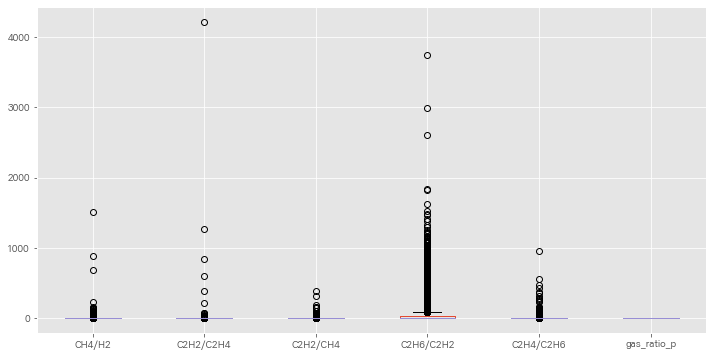

In [17]:
df[['CH4/H2', 'C2H2/C2H4', 'C2H2/CH4', 'C2H6/C2H2', 'C2H4/C2H6', 
    'gas_ratio_p']].boxplot(figsize = (12, 6))

In [18]:
df[df['gas_ratio_p']==5].shape
# 5가지 가스가 모두 정상적으로 계산된 경우는 매우 적음: 2669개(활용 단계 참고)

(2517, 46)

3) **Gas Rate:** dH2, dC2H2, dC2H4, dC2H6, dC3H8, dCO, dCO2, dTCG1, dTCG2, dTG 컬럼 추가

In [19]:
names = df['name'].unique()

In [20]:
tmp = []
for name in tqdm(names):
    df_tmp = df[df['name']==name].sort_values(by= 'sample_date')
    for i in range(df_tmp.shape[0]):
        row = df_tmp.iloc[i].to_dict()
        if i ==0:
            row['dH2'] = 0.; row['dC2H2'] = 0.; row['dC2H4'] = 0.; 
            row['dC2H6'] = 0.; row['dC3H8']= 0.; 
            row['dCO'] = 0.; row['dCO2'] = 0.;
            row['dTCG1'] = 0.; row['dTCG2'] = 0.; row['dTG'] = 0.;
            row['sample_cnt'] = 1

        else:
            row['dH2'] = (row['H2'] - row_old['H2'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dC2H2'] = (row['C2H2'] - row_old['C2H2'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)

            row['dC2H4'] = (row['C2H4'] - row_old['C2H4'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dC2H6'] = (row['C2H6'] - row_old['C2H6'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dC3H8'] = (row['C3H8'] - row_old['C3H8'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dCO'] = (row['CO'] - row_old['CO'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dCO2'] = (row['CO2'] - row_old['CO2'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dTCG1'] = (row['TCG1'] - row_old['TCG1'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dTCG2'] = (row['TCG2'] - row_old['TCG2'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['dTG'] = (row['TG'] - row_old['TG'])/\
                      abs(row['age(month)'] - row_old['age(month)']+1)
                
            row['sample_cnt'] = i+1
        
        tmp.append(row)
        row_old = row.copy()

In [21]:
df = pd.DataFrame(tmp)

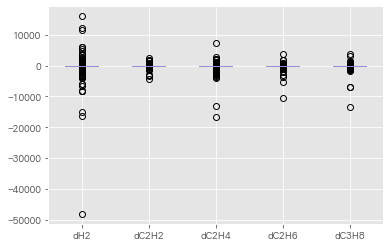

In [22]:
df[['dH2', 'dC2H2', 'dC2H4', 'dC2H6', 'dC3H8']].boxplot()

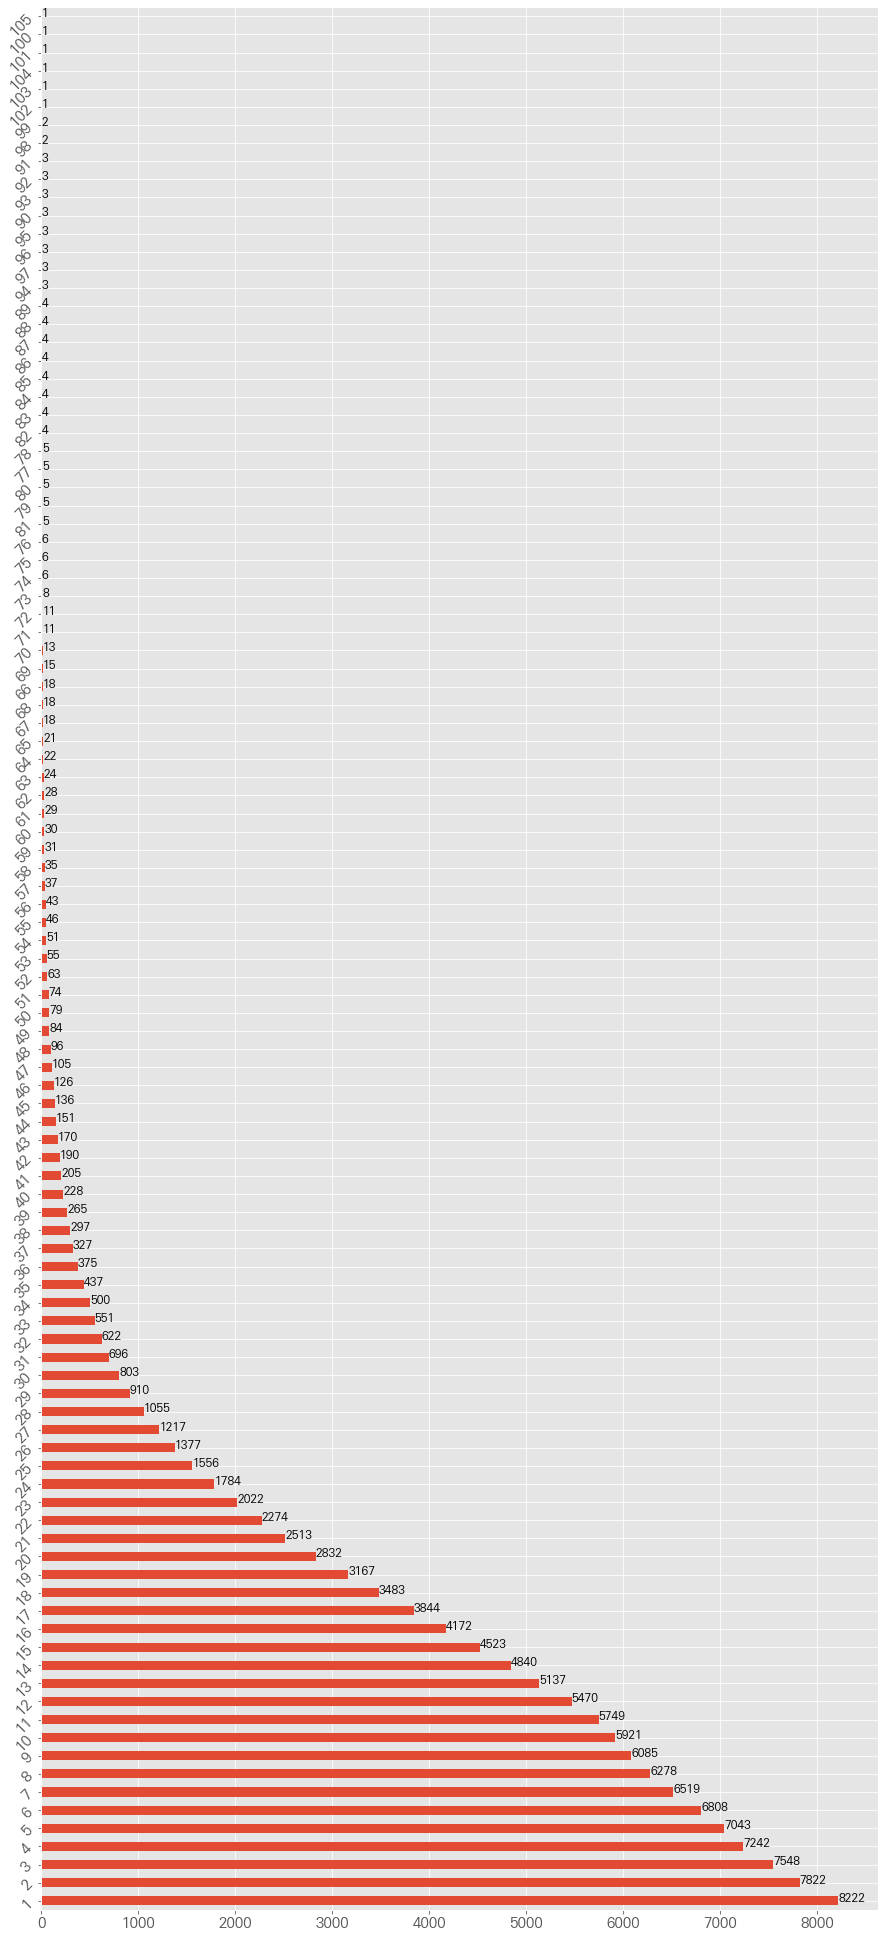

In [23]:
fig, ax = plt.subplots(figsize = (figure_hrz , 35))
df['sample_cnt'].value_counts(dropna = False).plot(kind = 'barh', rot = 45, fontsize = font_n)
for p in ax.patches:
    ax.text(p.get_width()+0.2, p.get_y()+0.2, str(p.get_width()), fontsize=font_d, color='k')
plt.show()
ax.set_title('Sample counts', fontsize = font_n)
ax.set_xlabel('Sample counts', fontsize = font_n)
ax.set_ylabel('counts', fontsize = font_n)
plt.show()

#### 완료 및 중간정리

In [24]:
df.columns

Index(['office1', 'office2', 'name', 'S/S', 'eq_type', 'eq_num', 'eq_phase',
       'maker', 'volt', 'volt_by_name', 'operation', 'anal_type', 'mfg_year',
       'sample_date', 'sample_year', 'sample_month', 'sample_season',
       'age(year)', 'age(month)', 'long_term', 'H2', 'C2H2', 'C2H4', 'CH4',
       'C2H6', 'C3H8', 'CO', 'CO2', 'r1(KEPCO)', 'r2(KEPCO)', 'etc', 'TCG1',
       'TCG2', 'TG', '%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO', 'CH4/H2',
       'C2H2/C2H4', 'C2H2/CH4', 'C2H6/C2H2', 'C2H4/C2H6', 'gas_ratio_p', 'dH2',
       'dC2H2', 'dC2H4', 'dC2H6', 'dC3H8', 'dCO', 'dCO2', 'dTCG1', 'dTCG2',
       'dTG', 'sample_cnt'],
      dtype='object')

In [25]:
tr_cols = ['office1', 'office2', 'name', 'S/S', 'eq_type', 'eq_num', 'eq_phase',
       'maker', 'volt', 'volt_by_name','operation', 'anal_type'] #11
date_cols = ['mfg_year', 'sample_date',  'sample_year','sample_month', 
            'sample_season', 'age(year)', 'age(month)','long_term','sample_cnt'] #
gas_cols = [ 'H2', 'C2H2', 'C2H4', 'CH4', 'C2H6', 'C3H8','CO', 'CO2',
           'TCG1', 'TCG2', 'TG', 
            '%H2', '%C2H2', '%C2H4', '%CH4', '%C2H6', '%CO', 
            'CH4/H2', 'C2H2/C2H4', 'C2H2/CH4', 'C2H6/C2H2', 'C2H4/C2H6', 
            'gas_ratio_p', 
            'dH2','dC2H2', 'dC2H4', 'dC2H6', 'dC3H8', 'dCO', 'dCO2', 
            'dTCG1', 'dTCG2','dTG']
result_cols = ['r1(KEPCO)', 'r2(KEPCO)']
etc = ['etc']

In [26]:
set(df.columns) == set(tr_cols + date_cols + gas_cols + result_cols + etc)

True

In [27]:
df = df[tr_cols + date_cols + gas_cols + result_cols + etc]

In [28]:
df.head()

,office1,office2,name,S/S,eq_type,eq_num,eq_phase,maker,volt,volt_by_name,operation,anal_type,mfg_year,sample_date,sample_year,sample_month,sample_season,age(year),age(month),long_term,sample_cnt,H2,C2H2,C2H4,CH4,C2H6,C3H8,CO,CO2,TCG1,TCG2,TG,%H2,%C2H2,%C2H4,%CH4,%C2H6,%CO,CH4/H2,C2H2/C2H4,C2H2/CH4,C2H6/C2H2,C2H4/C2H6,gas_ratio_p,dH2,dC2H2,dC2H4,dC2H6,dC3H8,dCO,dCO2,dTCG1,dTCG2,dTG,r1(KEPCO),r2(KEPCO),etc
0,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,신설,NaN,1998,1998-06-20,1998,6,1,0,5,0,1,0.0,0.0,0.0,7.0,0.0,0.0,23.0,84.0,7.0,7.0,114.0,0.0,0.0,0.0,23.33,0.0,76.67,1.4,1.0,0.14286,1.0,1.0,1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,정상,정상,NaN
1,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,신설,NaN,1998,1998-11-26,1998,11,2,0,10,0,2,10.0,0.0,0.0,1.0,0.0,0.0,87.0,1738.0,11.0,11.0,1836.0,10.2,0.0,0.0,1.02,0.0,88.78,0.1,1.0,1.00000,1.0,1.0,1,1.666667,0.0,0.0,0.0,0.0,10.666667,275.666667,0.666667,0.666667,287.000000,정상,정상,NaN
2,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,신설,NaN,1998,1999-12-07,1999,12,3,1,23,0,3,0.0,0.0,0.0,3.0,0.0,0.0,108.0,1110.0,3.0,3.0,1221.0,0.0,0.0,0.0,2.70,0.0,97.30,0.6,1.0,0.33333,1.0,1.0,1,-0.714286,0.0,0.0,0.0,0.0,1.500000,-44.857143,-0.571429,-0.571429,-43.928571,정상,정상,NaN
3,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,신설,NaN,1998,2000-11-29,2000,11,2,2,34,0,4,0.0,0.0,0.0,2.0,0.0,0.0,203.0,679.0,2.0,2.0,884.0,0.0,0.0,0.0,0.98,0.0,99.02,0.4,1.0,0.50000,1.0,1.0,1,0.000000,0.0,0.0,0.0,0.0,7.916667,-35.916667,-0.083333,-0.083333,-28.083333,정상,정상,NaN
4,제주본부,제주전력지사,신서귀S/S 154kV #1 M.Tr A,신서귀S/S,M.Tr,#1,A,효성,154,154,운전중,NaN,1998,2001-12-10,2001,12,3,3,47,1,5,0.0,0.0,0.0,0.0,0.0,0.0,222.0,537.0,0.0,0.0,759.0,0.0,0.0,0.0,0.00,0.0,100.00,0.2,1.0,1.00000,1.0,1.0,0,0.000000,0.0,0.0,0.0,0.0,1.357143,-10.142857,-0.142857,-0.142857,-8.928571,정상,정상,NaN


In [29]:
df.shape

(134666, 57)

In [30]:
df.to_pickle('result4.pkl')